# Tutorial 6
Creating complex models:
* Creating units with multiport inputs.
* Creating new requirements.

## Part 1
### Units with multiport inputs
For some unit models, there may be several types of qualitatively different inputs. An example can be found in the `delta_linear` class of `custom_units.py`. This class, together with the `delta_synapse` class in in `synapses.py` implements a continuous-time version of the _delta_ learning rule.

The _delta_ learning rule is one of the most widespread forms of supervised learning in neural networks. Given a _training set_ consisting of  input vectors 
$(\bf{x_1}, \dots, \bf{x_n})$ and their corresponding desired outptus $(y_1, \dots, y_n)$, the purpose of the delta rule is to adjust the input weights of a unit so
the response to $\bf{x_i}$ is $y_i$. Without going into details, this can sometimes be achieved by presenting the inputs one by one, each time adjusting the weights using:

$\Delta \omega_{j} = \alpha (y - u)x_j$,

where $y$ is the desired response to the input, $u$ is the actual response, $x_j$ is the $j$-th component of the input vector, $\omega_j$ is the corresponding weight, and $\alpha$ is a learning rate.  
To implement this, we require to know not only the input to the unit, but also the desired output. Since the error $e \equiv y - u$ is used by every synapse,
it is computationally efficient to calculate it once in the unit class and make it available to all synapses. Thus, the error is a synaptic _requirement_ that must be updated at every simulation step.

This tutorial is a guide to the source code in the `delta_linear`, and `delta_synapse` classes, which illustrate the tools used
to create units with multiple input ports, and synapses that use custom requirements.

In [19]:
# We can begin by looking at the docstring of the two classes
from draculab import *
help(delta_linear)

Help on class delta_linear in module custom_units:

class delta_linear(units.unit)
 |  A linear unit that modifies its weights using a continuous version of the delta rule.
 |  
 |  This unit scales its input vector so it has a unit L2 norm. Moreover, there is an implicit bias
 |  input that is always 1, and whose weight starts at 0 and changes with rate 'bias_lrate'.
 |  
 |  Units in this class have 3 input ports. 
 |  Port 0 is for the plastic synapses, which are of the delta_synapse class.
 |  Port 1 is for the desired value signal, which is used to produce the error.
 |  Port 2 is for the signal that indicates when to update the synaptic weights.
 |  
 |  The weight of the bias input is updated by the unit, whereas the weights of all inputs
 |  at port 0 are updated by their respective synapses, which must be of the 'delta' type.
 |  These synapses update their weight using: w' = alpha * error * pre, where alpha controls
 |  the learning rate, error is the scaled input sum at port

In [18]:
help(delta_synapse)

Help on class delta_synapse in module synapses:

class delta_synapse(synapse)
 |  A synapse that implements a continuous version of the delta rule.
 |  
 |  The discrete delta rule produces a weight update given by:
 |  Delta_w = alpha * (des - post) * pre, 
 |  where alpha is a learning rate, des is a desired output for the postsynaptic unit,
 |  post is the output of the postsynaptic unit, and pre is the input from the
 |  presynaptic unit.
 |  
 |  The version implemented here assumes that the error (des-post) is provided by the 
 |  postsynaptic unit, and has weight dynamics given by:
 |  w' = alpha * error * pre.
 |  
 |  An alternative version (commented-out code) is:
 |  w' = alpha * error * (pre -pre_lpf_slow) 
 |  
 |  Weight clipping is used to ensure that the weights of excitatory synapses don't
 |  become negative, and the weights of inhibitory synapses don't become positive. To
 |  decide whether a synapse is excitatory or inhibitory, the value of 'init_w' is used.
 |  Whe

[array([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11]]), array([[4, 5, 6, 7]])]

## Part 2
### ei_net
Now we will create a delta unit and test it using random input vectors with unit norm.
The desired output will be the norm of the projection of the input vector with a given vector $\bf{v}$.
If the learning algorithm works, the weight vector of the delta unit must approach $\bf{v}$.

To create this simulation we use the `ei_net` class from `ei_net.py`.  
This class is used to run simulations involving three different populations, called **e**, **i**, and **x**.  
These three populations are meant to contain excitatory, inhibitory, and source units respectively. An instance of the `ei_net` class contains default parameter dictionaries for the three populations, and for their connections. In theory we could just create an instance of `ei_net`, run `ei_net.build`, and then start running simulations with `ei_net.run`. Of course, those simulations would not use the network we want to simulate, so we need to adapt the parameters of `ei_net` for this end.

We want the **e** population to contain a single `delta_linear` unit, the **i** population to be empty, and the **x** population to contain __inp_dim__ source units, where __inp_dim__ stands for the dimensionality of the input vectors.

In [29]:
import numpy as np
# Create the input vectors
inp_dim = 10  # dimensionality of the input vectors
n_inp = 100  # number of input vectors
inps = np.zeros((inp_dim, n_inp))
for col in range(n_inp):
    vec = np.random.uniform(0., 1., inp_dim)
    inps[:, col] = vec / np.linalg.norm(vec)
    
# Create the desired outputs
v = np.zeros(inp_dim)
v[0::2] = 1. # about half of the entries are non-zero
v = v / np.linalg.norm(v)
des_out = np.zeros(n_inp)
for idx in range(n_inp):
    des_out[idx] = np.dot(v, inps[:, idx])

# Specify how long you will present each input
pres_time = 1.

# These methods return functions providing the inputs as continuous time functions
def cont_input(entry, pres_time):
    return lambda t : ( inps[entry,int(t//pres_time)] + ((t%pres_time)/pres_time) *
                      (inps[entry,max(int(t//pres_time)+1, n_inp-1)] - inps[entry,int(t//pres_time)]) )

[0.14970888 0.13771542 0.17286141 0.21396512 0.46388254 0.31884652
 0.36345077 0.2509728  0.23359477 0.17816396]


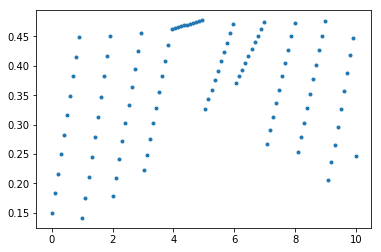

In [34]:
import matplotlib.pyplot as plt
inp2 = cont_input(2, pres_time)
print(inps[2,0:10])
ts = np.linspace(0,10,100)
plt.plot(ts, [inp2(t) for t in ts], '.')
plt.show()